In [67]:
import pyscf
import numpy as np
import matplotlib.pyplot as plt
from pyscf import lib, df
lib.param.MAX_MEMORY = 8000

In [64]:
mol = pyscf.gto.Mole()
mol.atom = """
O
H 1 0.96
H 1 0.96 2 104.5
"""
mol.symmetry = False
mol.basis = 'pcseg-1'
mol.verbose = 4
mol.build()

mf = pyscf.scf.RHF(mol).density_fit()
mf.conv_tol = 1e-10
mf.conv_tol_grad = 1e-8
mf.init_guess = 'atom'

D_guess = mf.get_init_guess(mol, key='atom')

mf.kernel(dm0=D_guess)

# get density matrix
D_pq = mf.make_rdm1()


System: uname_result(system='Linux', node='Deep-Thought', release='5.15.167.4-microsoft-standard-WSL2', version='#1 SMP Tue Nov 5 00:21:55 UTC 2024', machine='x86_64')  Threads 24
Python 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
numpy 2.1.2  scipy 1.14.1  h5py 3.13.0
Date: Fri Mar  7 12:18:17 2025
PySCF version 2.8.0
PySCF path  /home/etschgi1/miniconda3/envs/scf_dev/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 3
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 O      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  2 H      0.960000000000   0.000000000000   0.000000000000 

The difference in energy between psi4 and pyscf gets smaller if pyscf runs without .density_fit()

Text(0.5, 1.0, 'Converged density')

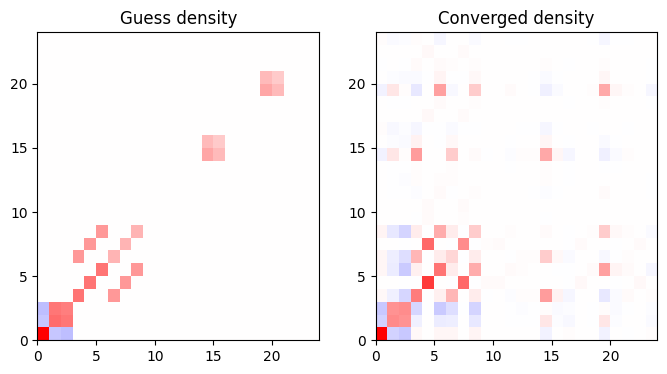

In [65]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2)

ax[0].pcolormesh(D_guess, cmap="bwr", vmin=-1.1, vmax=1.1)
ax[0].set_title("Guess density")
ax[1].pcolormesh(D_pq, cmap="bwr", vmin=-1.1, vmax=1.1)
ax[1].set_title("Converged density")

Total energy difference:  6.0276519548096985e-05


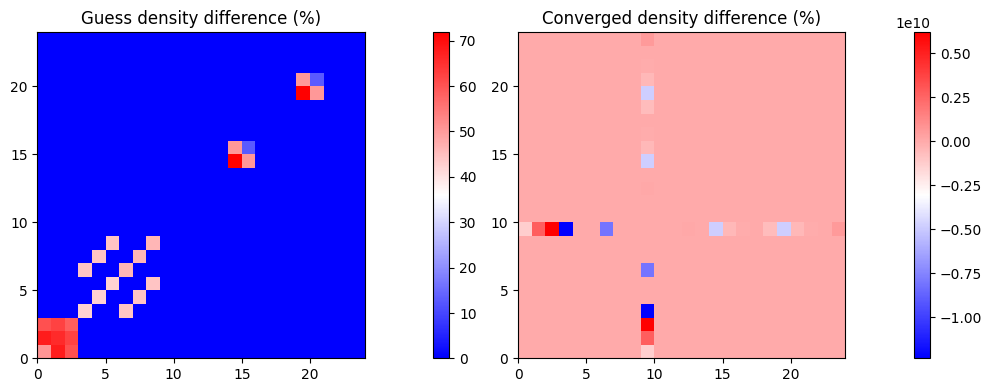

In [66]:
# get psi4 ref
import pickle
with open('data/psi4_density.pkl', 'rb') as f:
    psi4_e = pickle.load(f)
    psi4_D = pickle.load(f)
    psi4_D_guess = pickle.load(f)


eps = 1e-10

delta_e = np.abs(mf.e_tot - psi4_e)
delta_D =  100* (D_pq - psi4_D) / (D_pq+eps)
delta_D_guess = 100*(D_guess - psi4_D_guess) / (D_guess+eps)

print("Total energy difference: ", delta_e)
fig, ax = plt.subplots(figsize=(10, 4), ncols=4, width_ratios=[1, 0.05, 1, 0.05])
ax[0].pcolormesh(delta_D_guess, cmap="bwr")
ax[0].set_title("Guess density difference (%)")
plt.colorbar(ax[0].pcolormesh(delta_D_guess, cmap="bwr"), cax=ax[1])
ax[2].pcolormesh(delta_D, cmap="bwr")
ax[2].set_title("Converged density difference (%)")
plt.colorbar(ax[2].pcolormesh(delta_D, cmap="bwr"), cax=ax[3])
fig.tight_layout(pad=1.0)



In [ ]:
# mol already defines our basis
# but def2-universal-jkfit is not in the basis set list -> so we have to parse it manually 
with open('data/def2-universal-jkfit.1.nw', 'r') as f:
    def2_uni_jkfit_string = "".join(f.readlines())
def2_uni_jkfit = pyscf.gto.basis.parse(def2_uni_jkfit_string)
df_basis = df.addons.make_auxmol(mol, auxbasis=def2_uni_jkfit)

# let's try 3-center integrals
gdf = df.GDF(mol) #! Notice our auxbasis is probably not used here - need to investigate
gdf.build()
b_t_pq = gdf.get_eri()

V_tu = df.incore.aux_e2(mol, df_basis)
Vinv_tu = np.linalg.pinv(V_tu)

C_pq_u = np.einsum("tpq,tu->pqu", b_t_pq, Vinv_tu) #! Therefore we probably have wrong dimensions here!

******** <class 'pyscf.df.df.DF'> ********
auxbasis = None
max_memory = 4000
ETB for H: l = 0, exps = 0.2122 * 2^n , n = 0..6
ETB for H: l = 1, exps = 0.6514598989960932 * 2^n , n = 0..3
ETB for H: l = 2, exps = 2.0 * 2^n , n = 0..0
ETB for O: l = 0, exps = 0.570254 * 2^n , n = 0..12
ETB for O: l = 1, exps = 0.5285241540289337 * 2^n , n = 0..9
ETB for O: l = 2, exps = 0.489848 * 2^n , n = 0..7
ETB for O: l = 3, exps = 0.9897959385651166 * 2^n , n = 0..3
ETB for O: l = 4, exps = 2.0 * 2^n , n = 0..0

WARN: Even tempered Gaussians are generated as DF auxbasis for  H O



ValueError: einstein sum subscripts string contains too many subscripts for operand 0